In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
import re
from sentence_transformers import SentenceTransformer, util
import time
import torch
import spacy
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
import seaborn as sns

import lib.helper_pandas as hp



In [2]:
%%time
# @formatter:on

df = pd.read_parquet(path = './data/retail-transaction-clean-v1.parquet', engine = 'pyarrow')
n_rows = len(df.index)
n_cols = len(df.columns)
print(f"Dataframe length is: {len(df.index)}")
print(f"Number of columns is: {len(df.columns)}")

display(df.dtypes)
hp.unique_col_percent(df = df)
hp.null_val_summary(df = df)
df.head()



Dataframe length is: 528901
Number of columns is: 12


InvoiceNo                string
StockCode                string
Description              string
Quantity                  int64
InvoiceDate      datetime64[ns]
UnitPrice               float64
CustomerID                int64
Country                  string
InvoiceNoNum              int64
StockCodeNum              int64
StockCodeChar            string
TotalPrice              float64
dtype: object

InvoiceNo unique count and percentage: 20513, 3.88
StockCode unique count and percentage: 3805, 0.72
Description unique count and percentage: 4039, 0.76
Quantity unique count and percentage: 390, 0.07
InvoiceDate unique count and percentage: 18877, 3.57
UnitPrice unique count and percentage: 901, 0.17
CustomerID unique count and percentage: 4336, 0.82
Country unique count and percentage: 38, 0.01
InvoiceNoNum unique count and percentage: 20513, 3.88
StockCodeNum unique count and percentage: 3289, 0.62
StockCodeChar unique count and percentage: 28, 0.01
TotalPrice unique count and percentage: 4865, 0.92


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice
column type,string,string,string,int64,datetime64[ns],float64,int64,string,int64,int64,string,float64
null values (nb),0,0,0,0,0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Wall time: 1.43 s


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice
0,536365,85123a,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850,united kingdom,536365,85123,a,15.30
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850,united kingdom,536365,71053,,20.34
2,536365,84406b,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850,united kingdom,536365,84406,b,22.00
3,536365,84029g,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850,united kingdom,536365,84029,g,20.34
4,536365,84029e,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850,united kingdom,536365,84029,e,20.34


white hanging heart t-light holder    2327
jumbo bag red retrospot               2115
regency cakestand 3 tier              2019
party bunting                         1707
lunch bag red retrospot               1594
assorted colour bird ornament         1489
set of 3 cake tins pantry design      1401
pack of 72 retrospot cake cases       1370
lunch bag  black skull.               1328
natural slate heart chalkboard        1263
Name: Description, dtype: Int64

set of 3 wooden heart decorations     487
vintage union jack bunting            487
doormat spotty home sweet home        486
small heart measuring spoons          485
set/3 red gingham rose storage box    482
ladies & gentlemen metal sign         482
feltcraft cushion owl                 481
party metal sign                      480
natural slate chalkboard large        479
3 stripey mice feltcraft              479
Name: Description, dtype: Int64

wire flower t-light holder             1
letter "u" bling key ring              1
black glass/shell/pearl necklace       1
for online retail orders               1
cat with sunglasses blank card         1
small tahiti beach bag                 1
allocate stock for dotcom orders ta    1
wrongly sold (22719) barcode           1
blue new baroque flock candlestick     1
paper craft , little birdie            1
Name: Description, dtype: Int64

Wall time: 1.73 s


<BarContainer object of 20 artists>

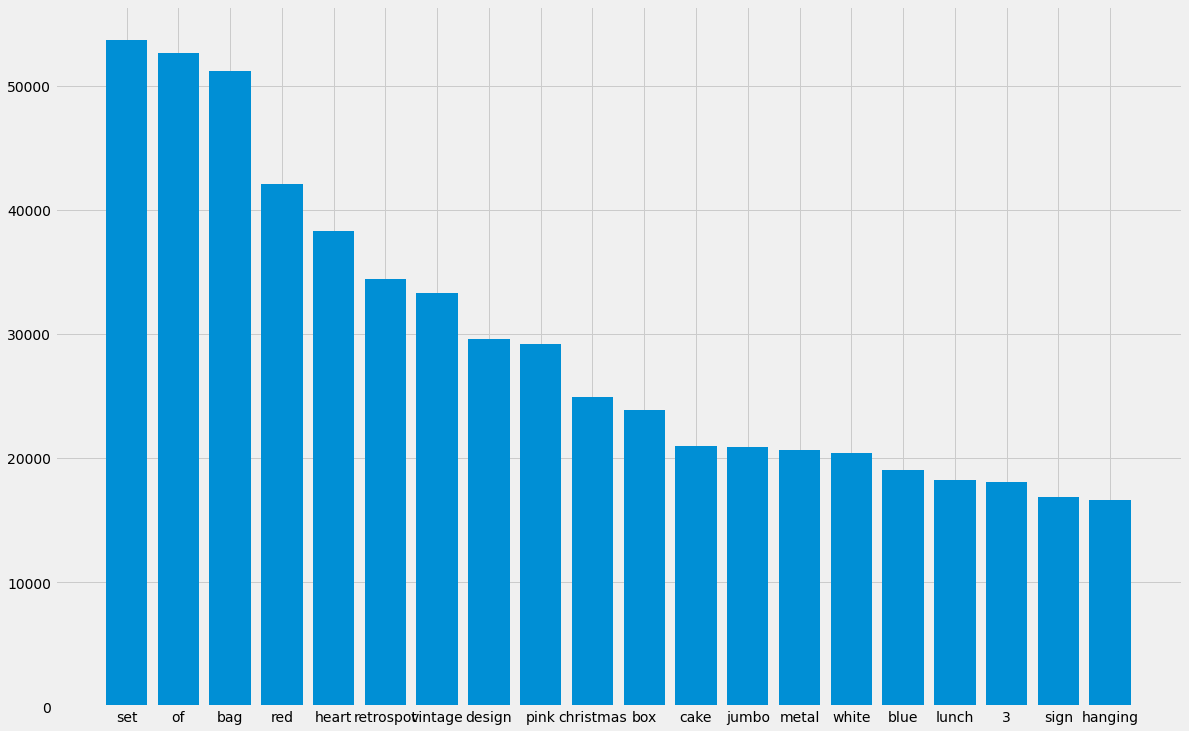

In [3]:
%%time
# @formatter:on

display(df['Description'].value_counts(dropna = False)[:10])
display(df['Description'].value_counts(dropna = False)[200:210])
display(df['Description'].value_counts(dropna = False)[-10:])

w = dict(Counter([i for j in df['Description'].str.split().tolist() for i in j]).most_common(20))
plt.style.use('fivethirtyeight')
plt.figure(figsize = (18, 12))
plt.bar(w.keys(), w.values())



In [4]:
%%time
# @formatter:on

# Remove cases
# ----- Expected output -----
# Before: THIS TEXT WILL BE LOWERCASED. THIS too: ßßß
# After: this text will be lowercased. this too: ssssss
# source: https://dylancastillo.co/nlp-snippets-clean-and-tokenize-text-with-python/#tokenize-text-using-spacy

def case_folder(text):
    return text.casefold()


df['DescriptionEdited'] = df['Description'].apply(lambda x: case_folder(x))
display(df['DescriptionEdited'].value_counts(dropna = False)[:10])
display(df['DescriptionEdited'].value_counts(dropna = False)[200:210])
display(df['DescriptionEdited'].value_counts(dropna = False)[-10:])
display(df.loc[~(df['DescriptionEdited'] == df['Description'])])
print(f"unique values count: {len(df['DescriptionEdited'].unique())}")



white hanging heart t-light holder    2327
jumbo bag red retrospot               2115
regency cakestand 3 tier              2019
party bunting                         1707
lunch bag red retrospot               1594
assorted colour bird ornament         1489
set of 3 cake tins pantry design      1401
pack of 72 retrospot cake cases       1370
lunch bag  black skull.               1328
natural slate heart chalkboard        1263
Name: DescriptionEdited, dtype: int64

set of 3 wooden heart decorations     487
vintage union jack bunting            487
doormat spotty home sweet home        486
small heart measuring spoons          485
ladies & gentlemen metal sign         482
set/3 red gingham rose storage box    482
feltcraft cushion owl                 481
party metal sign                      480
natural slate chalkboard large        479
3 stripey mice feltcraft              479
Name: DescriptionEdited, dtype: int64

jardin etched glass butter dish    1
vintage blue tinsel reel           1
pink bertie mobile phone charm     1
funky monkey mug                   1
bread bin, diner style, ivory      1
bread bin, diner style, mint       1
pink cherry lights                 1
blue crystal boot phone charm      1
happy birthday card teddy/cake     1
paper craft , little birdie        1
Name: DescriptionEdited, dtype: int64

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited


unique values count: 4039
Wall time: 440 ms


In [5]:
%%time
# @formatter:on

# removing numbers
# ----- Expected output -----
# Before: Remove these numbers: 1919191 2229292 11.233 22/22/22.
# After: Remove these numbers: .//.

def remove_number(text):
    #return re.sub(r"\b[0-9]+\b\s*", " ", text)
    return ''.join([i for i in text if not i.isdigit()])


df['DescriptionEditedTemp'] = df['DescriptionEdited'].apply(lambda x: remove_number(x))
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[:10])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[200:210])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[-10:])
display(df.loc[~(df['DescriptionEdited'] == df['DescriptionEditedTemp'])])
df['DescriptionEdited'] = df['DescriptionEditedTemp']
print(f"unique values count: {len(df['DescriptionEdited'].unique())}")



white hanging heart t-light holder    2327
jumbo bag red retrospot               2115
regency cakestand  tier               2019
party bunting                         1707
lunch bag red retrospot               1594
assorted colour bird ornament         1489
french blue metal door sign           1488
set of  cake tins pantry design       1401
pack of  retrospot cake cases         1370
lunch bag  black skull.               1328
Name: DescriptionEditedTemp, dtype: int64

lunch box with cutlery retrospot     489
pantry magnetic  shopping list       489
set of  wooden heart decorations     487
vintage union jack bunting           487
doormat spotty home sweet home       486
small heart measuring spoons         485
ladies & gentlemen metal sign        482
set/ red gingham rose storage box    482
feltcraft cushion owl                481
set  colour pencils spaceboy         481
Name: DescriptionEditedTemp, dtype: int64

pink small glass cake stand          1
ruby glass necklace "                1
wire flower t-light holder           1
wall art,only one person             1
wrongly sold () barcode              1
purple/turq flowers handbag          1
purple anemone artificial flower     1
blue drop earrings w bead cluster    1
wall art , the magic forest          1
paper craft , little birdie          1
Name: DescriptionEditedTemp, dtype: int64

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp
5,536365,22752,set 7 babushka nesting boxes,2,2010-12-01 08:26:00,7.65,17850,united kingdom,536365,22752,,15.30,set 7 babushka nesting boxes,set babushka nesting boxes
15,536367,84969,box of 6 assorted colour teaspoons,6,2010-12-01 08:34:00,4.25,13047,united kingdom,536367,84969,,25.50,box of 6 assorted colour teaspoons,box of assorted colour teaspoons
29,536370,21035,set/2 red retrospot tea towels,18,2010-12-01 08:45:00,2.95,12583,france,536370,21035,,53.10,set/2 red retrospot tea towels,set/ red retrospot tea towels
34,536370,22326,round snack boxes set of4 woodland,24,2010-12-01 08:45:00,2.95,12583,france,536370,22326,,70.80,round snack boxes set of4 woodland,round snack boxes set of woodland
42,536370,22900,set 2 tea towels i love london,24,2010-12-01 08:45:00,2.95,12583,france,536370,22900,,70.80,set 2 tea towels i love london,set tea towels i love london
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528876,581585,22398,magnets pack of 4 swallows,12,2011-12-09 12:31:00,0.39,15804,united kingdom,581585,22398,,4.68,magnets pack of 4 swallows,magnets pack of swallows
528877,581585,23328,set 6 school milk bottles in crate,4,2011-12-09 12:31:00,3.75,15804,united kingdom,581585,23328,,15.00,set 6 school milk bottles in crate,set school milk bottles in crate
528883,581586,23275,set of 3 hanging owls ollie beak,24,2011-12-09 12:49:00,1.25,13113,united kingdom,581586,23275,,30.00,set of 3 hanging owls ollie beak,set of hanging owls ollie beak
528897,581587,22613,pack of 20 spaceboy napkins,12,2011-12-09 12:50:00,0.85,12680,france,581587,22613,,10.20,pack of 20 spaceboy napkins,pack of spaceboy napkins


unique values count: 3979
Wall time: 1.81 s


In [6]:
%%time
# @formatter:on

# removing possessive and verb s

def remove_possessive(text):
    return text.replace("'s", '')


df['DescriptionEditedTemp'] = df['DescriptionEdited'].apply(lambda x: remove_possessive(x))
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[:10])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[200:210])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[-10:])
display(df.loc[~(df['DescriptionEdited'] == df['DescriptionEditedTemp'])])
df['DescriptionEdited'] = df['DescriptionEditedTemp']
print(f"unique values count: {len(df['DescriptionEdited'].unique())}")



white hanging heart t-light holder    2327
jumbo bag red retrospot               2115
regency cakestand  tier               2019
party bunting                         1707
lunch bag red retrospot               1594
assorted colour bird ornament         1489
french blue metal door sign           1488
set of  cake tins pantry design       1401
pack of  retrospot cake cases         1370
lunch bag  black skull.               1328
Name: DescriptionEditedTemp, dtype: int64

lunch box with cutlery retrospot     489
pantry magnetic  shopping list       489
set of  wooden heart decorations     487
vintage union jack bunting           487
doormat spotty home sweet home       486
small heart measuring spoons         485
ladies & gentlemen metal sign        482
set/ red gingham rose storage box    482
feltcraft cushion owl                481
set  colour pencils spaceboy         481
Name: DescriptionEditedTemp, dtype: int64

pink small glass cake stand          1
ruby glass necklace "                1
wire flower t-light holder           1
wall art,only one person             1
wrongly sold () barcode              1
purple/turq flowers handbag          1
purple anemone artificial flower     1
blue drop earrings w bead cluster    1
wall art , the magic forest          1
paper craft , little birdie          1
Name: DescriptionEditedTemp, dtype: int64

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp
11,536367,22745,poppy's playhouse bedroom,6,2010-12-01 08:34:00,2.10,13047,united kingdom,536367,22745,,12.60,poppy's playhouse bedroom,poppy playhouse bedroom
12,536367,22748,poppy's playhouse kitchen,6,2010-12-01 08:34:00,2.10,13047,united kingdom,536367,22748,,12.60,poppy's playhouse kitchen,poppy playhouse kitchen
45,536371,22086,paper chain kit 50's christmas,80,2010-12-01 09:00:00,2.55,13748,united kingdom,536371,22086,,204.00,paper chain kit 's christmas,paper chain kit christmas
116,536381,22086,paper chain kit 50's christmas,4,2010-12-01 09:41:00,2.95,15311,united kingdom,536381,22086,,11.80,paper chain kit 's christmas,paper chain kit christmas
373,536402,22086,paper chain kit 50's christmas,40,2010-12-01 11:22:00,2.55,15513,united kingdom,536402,22086,,102.00,paper chain kit 's christmas,paper chain kit christmas
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528686,581538,23319,box of 6 mini 50's crackers,1,2011-12-09 11:34:00,2.49,14446,united kingdom,581538,23319,,2.49,box of mini 's crackers,box of mini crackers
528804,581579,22086,paper chain kit 50's christmas,12,2011-12-09 12:19:00,2.95,17581,united kingdom,581579,22086,,35.40,paper chain kit 's christmas,paper chain kit christmas
528807,581579,23319,box of 6 mini 50's crackers,12,2011-12-09 12:19:00,2.49,17581,united kingdom,581579,23319,,29.88,box of mini 's crackers,box of mini crackers
528825,581579,23344,jumbo bag 50's christmas,20,2011-12-09 12:19:00,1.79,17581,united kingdom,581579,23344,,35.80,jumbo bag 's christmas,jumbo bag christmas


unique values count: 3979
Wall time: 443 ms


In [7]:
%%time
# @formatter:on

# removing special characters
# ----- Expected output -----
# Before: Sample text 123 !!!! Haha.... !!!! ##$$$%%%%
# After: Sample text 123  Haha

def remove_special_char(text):
    return re.sub(r"[^A-Za-z0-9\s]+", "", text)


df['DescriptionEditedTemp'] = df['DescriptionEdited'].apply(lambda x: remove_special_char(x))
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[:10])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[200:210])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[-10:])
display(df.loc[~(df['DescriptionEdited'] == df['DescriptionEditedTemp'])])
df['DescriptionEdited'] = df['DescriptionEditedTemp']
print(f"unique values count: {len(df['DescriptionEdited'].unique())}")



white hanging heart tlight holder    2327
jumbo bag red retrospot              2115
regency cakestand  tier              2019
party bunting                        1707
lunch bag red retrospot              1594
assorted colour bird ornament        1489
french blue metal door sign          1488
set of  cake tins pantry design      1401
pack of  retrospot cake cases        1370
lunch bag  black skull               1328
Name: DescriptionEditedTemp, dtype: int64

jumbo bag vintage christmas         489
lunch box with cutlery retrospot    489
set of  wooden heart decorations    487
vintage union jack bunting          487
doormat spotty home sweet home      486
small heart measuring spoons        485
set red gingham rose storage box    482
ladies  gentlemen metal sign        482
feltcraft cushion owl               481
set  colour pencils spaceboy        481
Name: DescriptionEditedTemp, dtype: int64

pink acrylic jewel snowflake       1
green pendant shell necklace       1
happy birthday card teddycake      1
filigree diamante chain            1
blossom images scrap book set      1
mint diner clock                   1
curious images scrap book set      1
pink painted kashmiri chair        1
blue gingham rose cushion cover    1
paper craft  little birdie         1
Name: DescriptionEditedTemp, dtype: int64

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp
0,536365,85123a,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850,united kingdom,536365,85123,a,15.30,white hanging heart t-light holder,white hanging heart tlight holder
4,536365,84029e,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850,united kingdom,536365,84029,e,20.34,red woolly hottie white heart.,red woolly hottie white heart
6,536365,21730,glass star frosted t-light holder,6,2010-12-01 08:26:00,4.25,17850,united kingdom,536365,21730,,25.50,glass star frosted t-light holder,glass star frosted tlight holder
29,536370,21035,set/2 red retrospot tea towels,18,2010-12-01 08:45:00,2.95,12583,france,536370,21035,,53.10,set/ red retrospot tea towels,set red retrospot tea towels
48,536373,85123a,white hanging heart t-light holder,6,2010-12-01 09:02:00,2.55,17850,united kingdom,536373,85123,a,15.30,white hanging heart t-light holder,white hanging heart tlight holder
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528859,581584,85038,6 chocolate love heart t-lights,48,2011-12-09 12:25:00,1.85,13777,united kingdom,581584,85038,,88.80,chocolate love heart t-lights,chocolate love heart tlights
528861,581585,84945,multi colour silver t-light holder,24,2011-12-09 12:31:00,0.85,15804,united kingdom,581585,84945,,20.40,multi colour silver t-light holder,multi colour silver tlight holder
528864,581585,22178,victorian glass hanging t-light,12,2011-12-09 12:31:00,1.95,15804,united kingdom,581585,22178,,23.40,victorian glass hanging t-light,victorian glass hanging tlight
528875,581585,84946,antique silver t-light glass,12,2011-12-09 12:31:00,1.25,15804,united kingdom,581585,84946,,15.00,antique silver t-light glass,antique silver tlight glass


unique values count: 3969
Wall time: 1.25 s


In [8]:
%%time
# @formatter:on

# removing words with less than 3 character

def remove_short_word(text):
    return re.sub(r'\b\w{1,2}\b', '', text)


df['DescriptionEditedTemp'] = df['DescriptionEdited'].apply(lambda x: remove_short_word(x))
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[:10])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[200:210])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[-10:])
display(df.loc[~(df['DescriptionEdited'] == df['DescriptionEditedTemp'])])
df['DescriptionEdited'] = df['DescriptionEditedTemp']
print(f"unique values count: {len(df['DescriptionEdited'].unique())}")



white hanging heart tlight holder    2327
jumbo bag red retrospot              2115
regency cakestand  tier              2019
party bunting                        1707
french blue metal door sign          1653
lunch bag red retrospot              1594
assorted colour bird ornament        1489
set   cake tins pantry design        1401
pack   retrospot cake cases          1370
lunch bag  black skull               1328
Name: DescriptionEditedTemp, dtype: int64

pantry magnetic  shopping list      489
jumbo bag vintage christmas         489
lunch box with cutlery retrospot    489
set   wooden heart decorations      487
vintage union jack bunting          487
doormat spotty home sweet home      486
small heart measuring spoons        485
ladies  gentlemen metal sign        482
set red gingham rose storage box    482
set  colour pencils spaceboy        481
Name: DescriptionEditedTemp, dtype: int64

glass bead hoop necklace black        1
baroque butterfly earrings montana    1
zinc plant pot holder                 1
zinc star tlight holder               1
incorrectly credited  see             1
capiz chandelier                      1
  cutlery set pantry design           1
lily brooch whitesilver colour        1
pearl  shell neckl ivory              1
paper craft  little birdie            1
Name: DescriptionEditedTemp, dtype: int64

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp
9,536367,22622,box of vintage alphabet blocks,2,2010-12-01 08:34:00,9.95,13047,united kingdom,536367,22622,,19.90,box of vintage alphabet blocks,box vintage alphabet blocks
15,536367,84969,box of 6 assorted colour teaspoons,6,2010-12-01 08:34:00,4.25,13047,united kingdom,536367,84969,,25.50,box of assorted colour teaspoons,box assorted colour teaspoons
16,536367,22623,box of vintage jigsaw blocks,3,2010-12-01 08:34:00,4.95,13047,united kingdom,536367,22623,,14.85,box of vintage jigsaw blocks,box vintage jigsaw blocks
34,536370,22326,round snack boxes set of4 woodland,24,2010-12-01 08:45:00,2.95,12583,france,536370,22326,,70.80,round snack boxes set of woodland,round snack boxes set woodland
36,536370,22659,lunch box i love london,24,2010-12-01 08:45:00,1.95,12583,france,536370,22659,,46.80,lunch box i love london,lunch box love london
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528877,581585,23328,set 6 school milk bottles in crate,4,2011-12-09 12:31:00,3.75,15804,united kingdom,581585,23328,,15.00,set school milk bottles in crate,set school milk bottles crate
528883,581586,23275,set of 3 hanging owls ollie beak,24,2011-12-09 12:49:00,1.25,13113,united kingdom,581586,23275,,30.00,set of hanging owls ollie beak,set hanging owls ollie beak
528887,581587,22555,plasters in tin strongman,12,2011-12-09 12:50:00,1.65,12680,france,581587,22555,,19.80,plasters in tin strongman,plasters tin strongman
528890,581587,22556,plasters in tin circus parade,12,2011-12-09 12:50:00,1.65,12680,france,581587,22556,,19.80,plasters in tin circus parade,plasters tin circus parade


unique values count: 3936
Wall time: 1.26 s


In [9]:
%%time
# @formatter:on

# removing extra whitespaces

def remove_extra_whitespace_tabs(text):
    return re.sub(r'^\s*|\s\s*', ' ', text).strip()


df['DescriptionEditedTemp'] = df['DescriptionEdited'].apply(lambda x: remove_extra_whitespace_tabs(x))
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[:10])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[200:210])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[-10:])
display(df.loc[~(df['DescriptionEdited'] == df['DescriptionEditedTemp'])])
df['DescriptionEdited'] = df['DescriptionEditedTemp']
print(f"unique values count: {len(df['DescriptionEdited'].unique())}")



white hanging heart tlight holder    2327
jumbo bag red retrospot              2115
regency cakestand tier               2019
party bunting                        1707
french blue metal door sign          1653
lunch bag red retrospot              1594
assorted colour bird ornament        1489
set cake tins pantry design          1401
pack retrospot cake cases            1370
lunch bag black skull                1328
Name: DescriptionEditedTemp, dtype: int64

jumbo bag vintage christmas         489
lunch box with cutlery retrospot    489
pantry magnetic shopping list       489
set wooden heart decorations        487
vintage union jack bunting          487
doormat spotty home sweet home      486
small heart measuring spoons        485
ladies gentlemen metal sign         482
set red gingham rose storage box    482
set colour pencils spaceboy         481
Name: DescriptionEditedTemp, dtype: int64

pink painted kashmiri chair            1
fire polished glass neckl gold         1
pink marshmallow scarf knitting kit    1
acrylic jewel snowflakepink            1
vintage bead pink jewel stand          1
keep out girls door hanger             1
opulent velvet set candles             1
miseltoe heart wreath cream            1
doorknob ceramic ivory                 1
paper craft little birdie              1
Name: DescriptionEditedTemp, dtype: int64

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp
5,536365,22752,set 7 babushka nesting boxes,2,2010-12-01 08:26:00,7.65,17850,united kingdom,536365,22752,,15.30,set babushka nesting boxes,set babushka nesting boxes
9,536367,22622,box of vintage alphabet blocks,2,2010-12-01 08:34:00,9.95,13047,united kingdom,536367,22622,,19.90,box vintage alphabet blocks,box vintage alphabet blocks
15,536367,84969,box of 6 assorted colour teaspoons,6,2010-12-01 08:34:00,4.25,13047,united kingdom,536367,84969,,25.50,box assorted colour teaspoons,box assorted colour teaspoons
16,536367,22623,box of vintage jigsaw blocks,3,2010-12-01 08:34:00,4.95,13047,united kingdom,536367,22623,,14.85,box vintage jigsaw blocks,box vintage jigsaw blocks
34,536370,22326,round snack boxes set of4 woodland,24,2010-12-01 08:45:00,2.95,12583,france,536370,22326,,70.80,round snack boxes set woodland,round snack boxes set woodland
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528883,581586,23275,set of 3 hanging owls ollie beak,24,2011-12-09 12:49:00,1.25,13113,united kingdom,581586,23275,,30.00,set hanging owls ollie beak,set hanging owls ollie beak
528887,581587,22555,plasters in tin strongman,12,2011-12-09 12:50:00,1.65,12680,france,581587,22555,,19.80,plasters tin strongman,plasters tin strongman
528890,581587,22556,plasters in tin circus parade,12,2011-12-09 12:50:00,1.65,12680,france,581587,22556,,19.80,plasters tin circus parade,plasters tin circus parade
528897,581587,22613,pack of 20 spaceboy napkins,12,2011-12-09 12:50:00,0.85,12680,france,581587,22613,,10.20,pack spaceboy napkins,pack spaceboy napkins


unique values count: 3922
Wall time: 1.82 s


In [10]:
%%time
# @formatter:on

display(df['DescriptionEdited'].value_counts(dropna = False)[:10])
display(df['DescriptionEdited'].value_counts(dropna = False)[200:210])
display(df['DescriptionEdited'].value_counts(dropna = False)[-10:])



white hanging heart tlight holder    2327
jumbo bag red retrospot              2115
regency cakestand tier               2019
party bunting                        1707
french blue metal door sign          1653
lunch bag red retrospot              1594
assorted colour bird ornament        1489
set cake tins pantry design          1401
pack retrospot cake cases            1370
lunch bag black skull                1328
Name: DescriptionEdited, dtype: int64

jumbo bag vintage christmas         489
lunch box with cutlery retrospot    489
pantry magnetic shopping list       489
set wooden heart decorations        487
vintage union jack bunting          487
doormat spotty home sweet home      486
small heart measuring spoons        485
ladies gentlemen metal sign         482
set red gingham rose storage box    482
set colour pencils spaceboy         481
Name: DescriptionEdited, dtype: int64

pink painted kashmiri chair            1
fire polished glass neckl gold         1
pink marshmallow scarf knitting kit    1
acrylic jewel snowflakepink            1
vintage bead pink jewel stand          1
keep out girls door hanger             1
opulent velvet set candles             1
miseltoe heart wreath cream            1
doorknob ceramic ivory                 1
paper craft little birdie              1
Name: DescriptionEdited, dtype: int64

Wall time: 194 ms


In [11]:
%%time
# @formatter:on

# python -m spacy download en_core_web_md
nlp = spacy.load("en_core_web_md", disable = ['parser', 'ner'])
print(nlp.pipe_names)



['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']
Wall time: 1.17 s


In [12]:
%%time
# @formatter:on

unique_desc = list(df['DescriptionEdited'].unique())

# New stop words list
customized_stop_words = [
    'alice blue', 'antique white',
    'aqua', 'aquamarine',
    'azure', 'beige',
    'bisque', 'black',
    'blanched almond', 'blue',
    'blue violet', 'brown',
    'burly wood', 'cadet blue',
    'chartreuse', 'chocolate',
    'coral', 'cornflower blue',
    'cornsilk', 'crimson',
    'cyan', 'dark blue',
    'dark cyan', 'dark golden rod',
    'dark gray', 'dark grey',
    'dark green', 'dark khaki',
    'dark magenta', 'dark olive green',
    'dark orange', 'dark orchid',
    'dark red', 'dark salmon',
    'dark sea green', 'dark slate blue',
    'dark slate gray', 'dark slate grey',
    'dark turquoise', 'dark violet',
    'deep pink', 'deep sky blue',
    'dim gray', 'dim grey',
    'dodger blue', 'fire brick',
    'floral white', 'forest green',
    'fuchsia', 'gainsboro',
    'ghost white', 'gold',
    'golden rod', 'gray',
    'grey', 'green',
    'green yellow', 'honey dew',
    'hot pink', 'indian red',
    'indigo', 'ivory',
    'khaki', 'lavender',
    'lavender blush', 'lawn green',
    'lemon chiffon', 'light blue',
    'light coral', 'light cyan',
    'light golden rod yellow',
    'light gray', 'light grey',
    'light green', 'light pink',
    'light salmon', 'light sea green',
    'light sky blue', 'light slate gray',
    'light slate grey', 'light steel blue',
    'light yellow', 'lime',
    'lime green', 'linen',
    'magenta', 'maroon',
    'medium aqua marine', 'medium blue',
    'medium orchid', 'medium purple',
    'medium sea green', 'medium slate blue',
    'medium spring green', 'medium turquoise',
    'medium violet red', 'midnight blue',
    'mint cream', 'misty rose', 'moccasin',
    'navajo white', 'navy',
    'old lace', 'olive',
    'olive drab', 'orange',
    'orange red', 'orchid',
    'pale golden rod', 'pale green',
    'pale turquoise', 'pale violet red',
    'papaya whip', 'peach puff',
    'peru', 'pink',
    'plum', 'powder blue',
    'purple', 'rebecca purple',
    'red', 'rosy brown',
    'royal blue', 'saddle brown',
    'salmon', 'sandy brown',
    'sea green', 'sea shell',
    'sienna', 'sky blue',
    'slate blue', 'slate gray',
    'slate grey', 'snow',
    'spring green', 'steel blue',
    'tan', 'teal',
    'thistle', 'tomato',
    'turquoise', 'violet',
    'wheat', 'white',
    'white smoke', 'yellow',
    'yellow green',

    #, 'silver'
    'set',

    'medium',
    'small', 'large',
    'giant',

    'wrongly code',
    'mark as',
    'wrongly mark'
]

# Mark them as stop words
for w in customized_stop_words:
    nlp.vocab[w].is_stop = True

res = []
for doc in tqdm(nlp.pipe(unique_desc, n_process = 2)):
    res.append(" ".join(token.lemma_ for token in doc if not token.is_stop))

for inx, item in enumerate(tqdm(unique_desc)):
    df.loc[df[df['DescriptionEdited'] == item].index, 'DescriptionEditedTemp'] = res[inx]

display(df['DescriptionEditedTemp'].value_counts(dropna = False)[:10])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[200:210])
display(df['DescriptionEditedTemp'].value_counts(dropna = False)[-10:])
display(df.loc[~(df['DescriptionEdited'] == df['DescriptionEditedTemp'])])
df['DescriptionEdited'] = df['DescriptionEditedTemp']
print(f"unique values count: {len(df['DescriptionEdited'].unique())}")



3922it [00:13, 291.78it/s] 
100%|██████████| 3922/3922 [04:01<00:00, 16.21it/s]


alarm clock bakelike        4340
heart wicker                3409
hang heart tlight holder    3163
jumbo bag retrospot         2115
regency cakestand tier      2019
regency teacup saucer       1837
party bunting               1707
french metal door sign      1653
lunch bag retrospot         1594
spot ceramic drawer knob    1552
Name: DescriptionEditedTemp, dtype: int64

cream heart card holder        531
kids cookie cutter             531
suki shoulder bag              531
spaceboy birthday card         530
plaster tin strongman          530
pack london tissue             529
cream sweetheart mini chest    529
airline bag vintage jet        528
jumbo bag toy                  525
assorted colour silk fan       519
Name: DescriptionEditedTemp, dtype: int64

bell heart antique                     1
gardener kneel pad                     1
country cottage doorstop               1
watering single hook pistachio         1
disco partition panel                  1
christmas table candle silver spike    1
wrap flock                             1
weekend bag vintage rise paisley       1
jardin etch glass butter dish          1
paper craft little birdie              1
Name: DescriptionEditedTemp, dtype: int64

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp
0,536365,85123a,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850,united kingdom,536365,85123,a,15.30,white hanging heart tlight holder,hang heart tlight holder
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850,united kingdom,536365,71053,,20.34,white metal lantern,metal lantern
2,536365,84406b,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850,united kingdom,536365,84406,b,22.00,cream cupid hearts coat hanger,cream cupid heart coat hanger
3,536365,84029g,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850,united kingdom,536365,84029,g,20.34,knitted union flag hot water bottle,knit union flag hot water bottle
4,536365,84029e,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850,united kingdom,536365,84029,e,20.34,red woolly hottie white heart,woolly hottie heart
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528892,581587,22730,alarm clock bakelike ivory,4,2011-12-09 12:50:00,3.75,12680,france,581587,22730,,15.00,alarm clock bakelike ivory,alarm clock bakelike
528894,581587,22899,children's apron dolly girl,6,2011-12-09 12:50:00,2.10,12680,france,581587,22899,,12.60,children apron dolly girl,child apron dolly girl
528897,581587,22613,pack of 20 spaceboy napkins,12,2011-12-09 12:50:00,0.85,12680,france,581587,22613,,10.20,pack spaceboy napkins,pack spaceboy napkin
528898,581587,23256,childrens cutlery spaceboy,4,2011-12-09 12:50:00,4.15,12680,france,581587,23256,,16.60,childrens cutlery spaceboy,children cutlery spaceboy


unique values count: 3461
Wall time: 4min 15s


Wall time: 1.93 s


<BarContainer object of 20 artists>

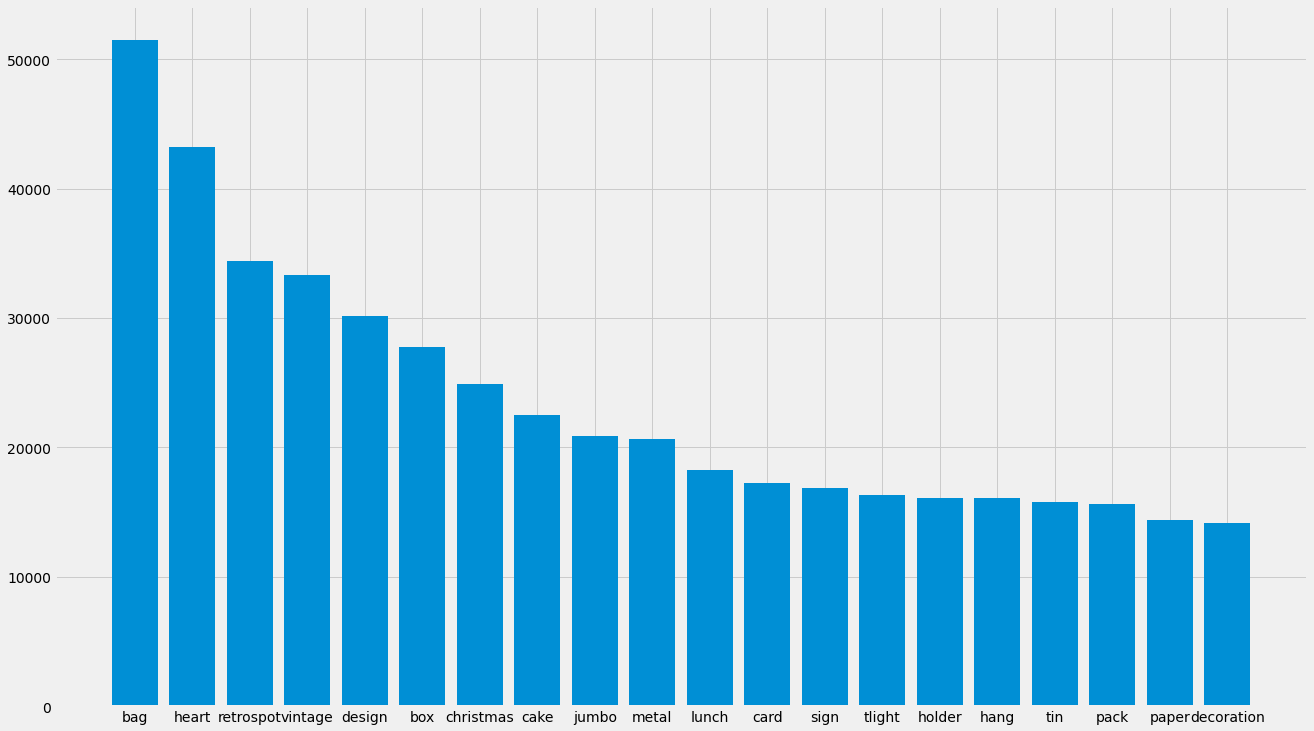

In [13]:
%%time
# @formatter:on

w = dict(Counter([i for j in df['DescriptionEdited'].str.split().tolist() for i in j]).most_common(20))
plt.style.use('fivethirtyeight')
plt.figure(figsize = (20, 12))
plt.bar(w.keys(), w.values())



{'allocate': 2, 'online': 2, 'find': 2, 'waterpump': 2, 'poinsettia': 2, 'minicard': 2, 'necklaceleaf': 2, 'amazon': 2, 'silt': 2, 'squ': 2, 'crome': 2, 'candleincense': 2, 'deck': 2, 'girly': 1, 'loveheart': 1, 'tinsel': 1, 'weekend': 1, 'blackchristmas': 1, 'boombox': 1, 'ipod': 1, 'demi': 1, 'choker': 1, 'opulent': 1, 'snowflakepink': 1, 'banner': 1, 'cutglass': 1, 'ooh': 1, 'bazaar': 1, 'bluenat': 1, 'scallop': 1, 'heavens': 1, 'fragrance': 1, 'purpleturq': 1, 'sell': 1, 'barcode': 1, 'rcvd': 1, 'temp': 1, 'flowerbutterfly': 1, 'mummy': 1, 'tick': 1, 'ret': 1, 'orangefuschia': 1, 'antoienett': 1, 'laser': 1, 'haynes': 1, 'camper': 1, 'whitesilver': 1, 'capiz': 1, 'incorrectly': 1, 'alan': 1, 'hodge': 1, 'mamage': 1, 'section': 1, 'beadshand': 1, 'fba': 1, 'teddycake': 1, 'add': 1, 'retail': 1, 'damage': 1, 'whse': 1, 'website': 1, 'draw': 1, 'trading': 1, 'zero': 1, 'invc': 1, 'incorr': 1, 'michel': 1, 'oops': 1, 'artonly': 1, 'partition': 1, 'panel': 1, 'sale': 1, 'error': 1, 'mir

<BarContainer object of 15 artists>

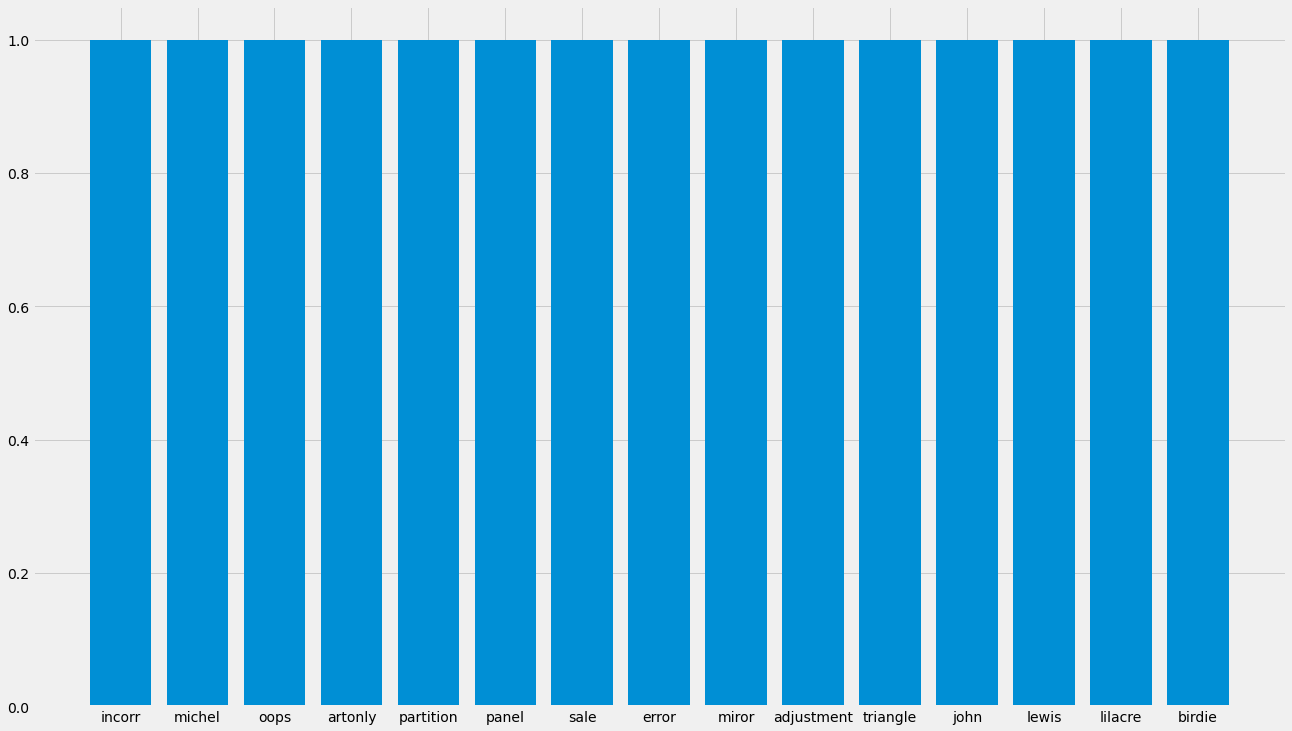

In [14]:
%%time
# @formatter:on

w = dict(Counter([i for j in df['DescriptionEdited'].str.split().tolist() for i in j]).most_common()[-80:])
print(w)
w = dict(Counter([i for j in df['DescriptionEdited'].str.split().tolist() for i in j]).most_common()[-15:])
plt.style.use('fivethirtyeight')
plt.figure(figsize = (20, 12))
plt.bar(w.keys(), w.values())



In [15]:
%%time
# @formatter:on

unique_products = df['StockCodeNum'].unique().tolist()
print(f'Count of unique products: {len(unique_products)}')
for inx, pr in enumerate(unique_products):
    pr_transact = df[df['StockCodeNum'] == pr]
    unique_pr_desc = list(pr_transact['DescriptionEdited'].unique())
    if len(unique_pr_desc) > 1:
        unique_pr_desc = unique_pr_desc[0]
        if inx % 150 == 0:
            display(df[df['StockCodeNum'] == pr].drop_duplicates(['DescriptionEdited', 'StockCodeChar']))
        df.loc[pr_transact.index, 'DescriptionEdited'] = unique_pr_desc
        if inx % 150 == 0:
            display(df[df['StockCodeNum'] == pr].drop_duplicates(['DescriptionEdited', 'StockCodeChar']))
    else:
        unique_products.remove(pr)

print(f'Count of unique products that have changed: {len(unique_products)}')



Count of unique products: 3289


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp
0,536365,85123a,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.550000,17850,united kingdom,536365,85123,a,15.300000,hang heart tlight holder,hang heart tlight holder
215109,556231,85123a,?,4000,2011-06-09 15:04:00,4.382222,-1,united kingdom,556231,85123,a,17528.888889,,
524673,581334,85123a,cream hanging heart t-light holder,4,2011-12-08 12:07:00,2.950000,17841,united kingdom,581334,85123,a,11.800000,cream hang heart tlight holder,cream hang heart tlight holder


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp
0,536365,85123a,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850,united kingdom,536365,85123,a,15.3,hang heart tlight holder,hang heart tlight holder


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp
8113,537133,22939,apron apple delight,2,2010-12-05 12:29:00,4.95,18156,united kingdom,537133,22939,,9.9,apron apple delight,apron apple delight
283569,562435,22939,adult apron apple delight,4,2011-08-04 17:51:00,4.95,12693,germany,562435,22939,,19.8,adult apron apple delight,adult apron apple delight


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp
8113,537133,22939,apron apple delight,2,2010-12-05 12:29:00,4.95,18156,united kingdom,537133,22939,,9.9,apron apple delight,apron apple delight


Count of unique products that have changed: 1757
Wall time: 4.22 s


In [16]:
%%time
# @formatter:on

df = df.drop(df[df['DescriptionEdited'] == ''].index)
print(f"unique values count: {len(df['DescriptionEdited'].unique())}")
print(f"Dataframe length is: {len(df.index)}")
print(f"Portion of dataframe that is removed so far: {(n_rows - len(df.index)) / n_rows * 100:.2f}%")


unique values count: 3182
Dataframe length is: 528898
Portion of dataframe that is removed so far: 0.00%
Wall time: 198 ms


In [3]:
%%time
# @formatter:on

#df.to_parquet(path = './data/temp-product-clustered-center-v1.parquet', engine = 'pyarrow')
df = pd.read_parquet(path = './data/temp-product-clustered-center-v1.parquet', engine = 'pyarrow')



Wall time: 1.01 s


In [43]:
%%time
# @formatter:on

model = SentenceTransformer('all-mpnet-base-v2')
#model = SentenceTransformer('all-MiniLM-L6-v2')
unique_corpus_sentences = list(df['DescriptionEdited'].unique())
corpus_embeddings = model.encode(unique_corpus_sentences,
                                 batch_size = 64,
                                 show_progress_bar = True,
                                 convert_to_tensor = True)

print("Start clustering")
start_time = time.time()
# Two parameters to tune:
# min_cluster_size: Only consider cluster that have at least min_cluster_size elements
# threshold: Consider sentence pairs with a cosine-similarity larger than threshold as similar
detected_clusters = util.community_detection(corpus_embeddings,
                                             min_community_size = 5,
                                             threshold = 0.75, )
print(f"Clustering done after {time.time() - start_time:.2f} sec")
print(f"Number of clusters: {len(detected_clusters)}")

for i, cluster in enumerate(detected_clusters):
    if i % 30 == 0:
        # The first element in each list is the central point in the community.
        print(f"Cluster {i + 1}, #{len(cluster)} Elements")
        for sentence_id in cluster[0:2]:
            print("\t", unique_corpus_sentences[sentence_id])





Batches:   0%|          | 0/50 [00:00<?, ?it/s]

Start clustering
Clustering done after 0.22 sec
Number of clusters: 79
Cluster 1, #22 Elements
	 silver hang tlight holder
	 multi colour silver tlight holder
Cluster 31, #7 Elements
	 silver orbit bracelet
	 silver orbit necklace
Cluster 61, #5 Elements
	 peace wooden block letter
	 noel wooden block letter
Wall time: 37.9 s


Batches:   0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 16/16 [14:11<00:00, 53.25s/it]


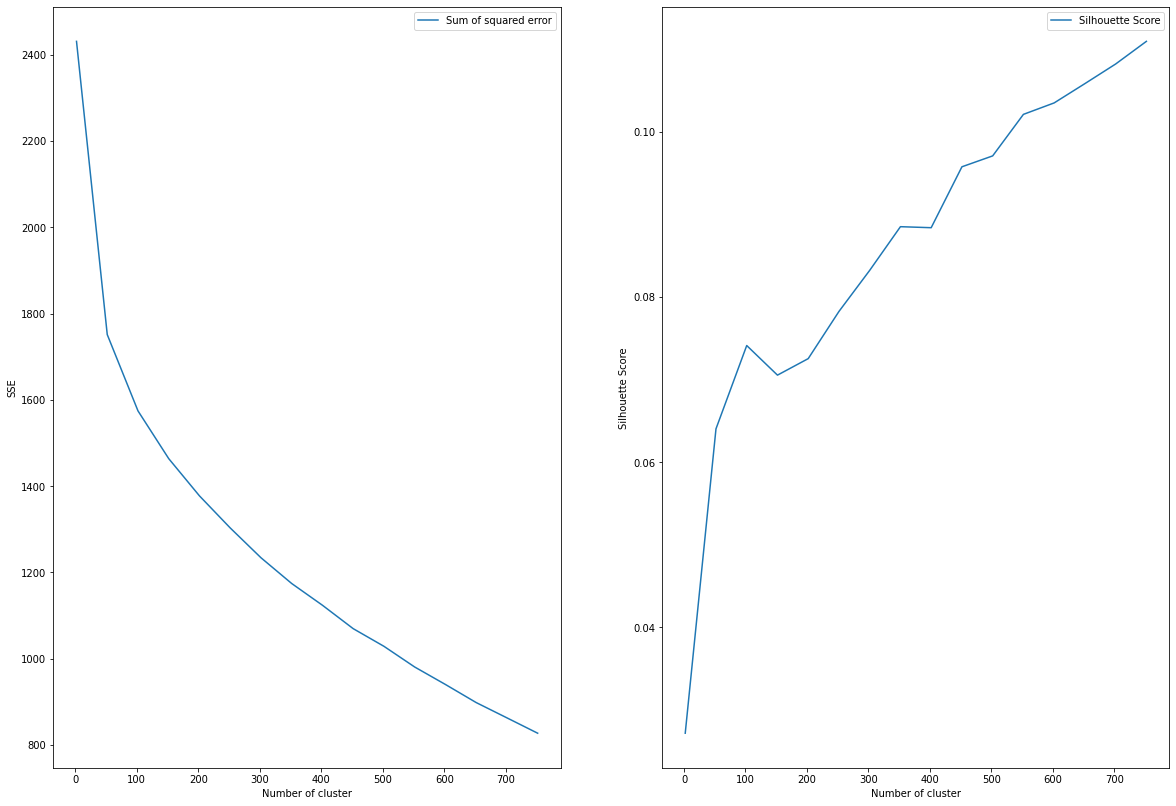

Wall time: 14min 52s


In [7]:
%%time
# @formatter:on

# K-means
if True:

    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score

    model = SentenceTransformer('all-mpnet-base-v2')
    #model = SentenceTransformer('all-MiniLM-L6-v2')
    unique_corpus_sentences = list(df['DescriptionEdited'].unique())
    corpus_embeddings = model.encode(unique_corpus_sentences,
                                     batch_size = 64,
                                     show_progress_bar = True,
                                     convert_to_tensor = False)

    # Perform k-mean clustering
    sse = {}
    kmeans_ref = {}
    silhouette_coefficient = {}
    for num_clusters in tqdm(range(2, 800, 50)):

        clustering_model = KMeans(n_clusters = num_clusters, random_state = 42)
        clustering_model.fit(corpus_embeddings)
        cluster_assignment = clustering_model.labels_

        sse[num_clusters] = clustering_model.inertia_
        clustered_sentences = [[] for i in range(num_clusters)]
        for sentence_id, cluster_id in enumerate(cluster_assignment):
            clustered_sentences[cluster_id].append(unique_corpus_sentences[sentence_id])

        silhouette_coefficient[num_clusters] = silhouette_score(corpus_embeddings, cluster_assignment)

        kmeans_ref[num_clusters] = clustered_sentences

    fig = plt.figure(figsize = (20, 14))
    fig.add_subplot(121)
    plt.plot(list(sse.keys()), list(sse.values()), label = 'Sum of squared error')
    plt.xlabel("Number of cluster")
    plt.ylabel("SSE")
    plt.legend()

    fig.add_subplot(122)
    plt.plot(list(silhouette_coefficient.keys()), list(silhouette_coefficient.values()), label = 'Silhouette Score')
    plt.xlabel("Number of cluster")
    plt.ylabel("Silhouette Score")
    plt.legend()
    plt.show()



In [6]:
%%time
# @formatter:on

if True:
    import pickle

    with open('./data/kmeans-clusters.pkl', 'wb') as handle:
        pickle.dump(kmeans_ref, handle, protocol = pickle.HIGHEST_PROTOCOL)

    # with open('./data/kmeans-clusters.pkl', 'rb') as handle:
    #     unserialized_data = pickle.load(handle)

    selected_n_cluster = 482
    for i, cluster in enumerate(kmeans_ref[selected_n_cluster]):
        df.loc[df[df['DescriptionEdited'].isin(cluster)].index, 'ClusterId'] = i
        if i % 50 == 0:
            print("Cluster ", i + 1)
            print(cluster)
            print("")

    hp.null_val_summary(df = df)



Cluster  1
['glass tassle bag charm', 'fruit salad bag charm', 'summer daisy bag charm', 'summer butterfly bag charm', 'amber glass tassle bag charm', 'bertie glass bead bag charm', 'daisy bag charm', 'metalic leave bag charm', 'metal bag charm', 'copper brass bag charm']

Cluster  51
['ribbon reel make snowman', 'ribbon reel snowy village', 'ribbon reel christmas present', 'ribbon reel sock mitten', 'ribbon reel stripe design', 'ribbon reel polkadot', 'ribbon reel flora fauna', 'ribbon reel lace design', 'vintage tinsel reel', 'ribbon reel heart design', 'embroidered ribbon reel emily', 'embroider ribbon reel ruby', 'embroidered ribbon reel rebecca', 'embroidered ribbon reel daisy', 'embroidered ribbon reel sally', 'embroidered ribbon reel rachel', 'embroidered ribbon reel rosie', 'embroidered ribbon reel susie', 'embroidered ribbon reel sophie', 'embroidered ribbon reel claire']

Cluster  101
['retrospot oven glove', 'tec alpine hand warm', 'retrospot oven glove double', 'tea time ov

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp,ClusterId
column type,string,string,string,int64,datetime64[ns],float64,int64,string,int64,int64,string,float64,object,object,float64
null values (nb),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Wall time: 13.3 s


In [ ]:
%%time
# @formatter:on

cluster_centers_embeddings = []
for i, cluster in enumerate(detected_clusters):
    cluster_unique_sentences = []
    cluster_centers_embeddings.append(corpus_embeddings[cluster[0]])
    for sentence_id in cluster:
        cluster_unique_sentences.append(unique_corpus_sentences[sentence_id])
    df.loc[df[df['DescriptionEdited'].isin(cluster_unique_sentences)].index, 'ClusterId'] = i

hp.null_val_summary(df = df)

unclustered_df = df[df['ClusterId'].isna()]

print(f"Total Quantity of unclustered sales: {unclustered_df['Quantity'].sum()}, "
      f"percentage: {unclustered_df['Quantity'].sum() / df['Quantity'].sum() * 100:0.2f}")

print(f"Total Quantity*UnitPrice of unclustered sales: {unclustered_df['TotalPrice'].sum():0.2f}, "
      f"percentage: {unclustered_df['TotalPrice'].sum() / df['TotalPrice'].sum() * 100:0.2f}")



In [45]:
%%time
# @formatter:on

df['StockCodeNumQuantitySum'] = df.groupby('StockCodeNum')['Quantity'].transform(sum)
df['StockCodeNumTotalPriceSum'] = df.groupby('StockCodeNum')['TotalPrice'].transform(sum)

# top product seller
display(df.sort_values(by = ['StockCodeNumQuantitySum'], ascending = False).drop_duplicates(subset = ['StockCodeNum']).head(10))
display(df.sort_values(by = ['StockCodeNumTotalPriceSum'], ascending = False).drop_duplicates(subset = ['StockCodeNum']).head(10))



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp,ClusterId,StockCodeNumQuantitySum,StockCodeNumTotalPriceSum
527427,581483,23843,"paper craft , little birdie",80995,2011-12-09 09:15:00,2.08,16446,united kingdom,581483,23843,,168469.60,paper craft little birdie,paper craft little birdie,NaN,80995,168469.600000
443262,575602,85099f,jumbo bag strawberry,2,2011-11-10 12:27:00,2.08,17059,united kingdom,575602,85099,f,4.16,jumbo bag strawberry,jumbo bag strawberry,58.0,79823,155556.869231
232050,557937,23166,medium ceramic top storage jar,1,2011-06-23 15:30:00,2.46,-1,united kingdom,557937,23166,,2.46,ceramic storage jar,ceramic storage jar,NaN,78033,81700.920000
220573,556804,22197,small popcorn holder,100,2011-06-14 15:14:00,0.72,15125,united kingdom,556804,22197,,72.00,popcorn holder,popcorn holder,NaN,56921,51354.020000
409534,572889,84077,world war 2 gliders asstd designs,48,2011-10-26 13:56:00,0.29,12748,united kingdom,572889,84077,,13.92,world war glider asstd design,world war glider asstd design,NaN,55047,13841.850000
81651,543345,85123a,white hanging heart t-light holder,2,2011-02-07 12:29:00,5.79,-1,united kingdom,543345,85123,a,11.58,hang heart tlight holder,hang heart tlight holder,0.0,41956,124017.697778
123789,547108,84879,assorted colour bird ornament,8,2011-03-21 11:36:00,1.69,14659,united kingdom,547108,84879,,13.52,assorted colour bird ornament,assorted colour bird ornament,NaN,36461,59094.930000
107111,545661,21212,pack of 72 retrospot cake cases,48,2011-03-04 14:41:00,0.55,15358,united kingdom,545661,21212,,26.40,pack retrospot cake case,pack retrospot cake case,NaN,36419,21259.100000
418877,573576,23084,rabbit night light,8,2011-10-31 14:09:00,4.13,14096,united kingdom,573576,23084,,33.04,rabbit night light,rabbit night light,NaN,31722,70012.943333
415650,573361,22492,mini paint set vintage,36,2011-10-30 12:53:00,0.65,14456,united kingdom,573361,22492,,23.40,mini paint vintage,mini paint vintage,NaN,26633,16937.820000


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp,ClusterId,StockCodeNumQuantitySum,StockCodeNumTotalPriceSum
272477,561367,22423,regency cakestand 3 tier,2,2011-07-26 15:46:00,24.96,-1,united kingdom,561367,22423,,49.92,regency cakestand tier,regency cakestand tier,59.0,13890,174653.125556
527427,581483,23843,"paper craft , little birdie",80995,2011-12-09 09:15:00,2.08,16446,united kingdom,581483,23843,,168469.60,paper craft little birdie,paper craft little birdie,NaN,80995,168469.600000
115825,546486,85099c,jumbo bag baroque black white,10,2011-03-14 11:41:00,1.95,15039,united kingdom,546486,85099,c,19.50,jumbo bag baroque,jumbo bag baroque,NaN,79823,155556.869231
139114,548636,85123a,white hanging heart t-light holder,12,2011-04-01 12:29:00,2.95,15601,united kingdom,548636,85123,a,35.40,hang heart tlight holder,hang heart tlight holder,0.0,41956,124017.697778
483049,578296,47566,party bunting,12,2011-11-23 14:51:00,4.95,16653,united kingdom,578296,47566,,59.40,tea time party bunting,party bunting,NaN,22180,122142.144000
278406,561926,23166,medium ceramic top storage jar,12,2011-08-01 12:48:00,1.25,12749,united kingdom,561926,23166,,15.00,ceramic storage jar,ceramic storage jar,NaN,78033,81700.920000
518846,580959,23084,rabbit night light,6,2011-12-06 14:31:00,2.08,14673,united kingdom,580959,23084,,12.48,rabbit night light,rabbit night light,NaN,31722,70012.943333
452874,576112,84997d,childrens cutlery polkadot pink,4,2011-11-14 10:34:00,4.15,14902,united kingdom,576112,84997,d,16.60,piece polkadot cutlery,children cutlery polkadot,NaN,16749,69181.420000
460559,576686,22086,paper chain kit 50's christmas,2,2011-11-16 12:08:00,2.95,16916,united kingdom,576686,22086,,5.90,paper chain kit christmas,paper chain kit christmas,NaN,19355,64952.290000
161738,550885,22502,picnic basket wicker small,4,2011-04-21 11:59:00,5.95,16185,united kingdom,550885,22502,,23.80,picnic basket wicker,picnic basket wicker,NaN,2048,60861.770000


Wall time: 1.23 s


In [46]:
%%time
# @formatter:on

stacked_centers_embeddings = torch.stack(cluster_centers_embeddings)
# average over cluster
unclustered_df = df[df['ClusterId'].isna()]
unclustered_embeddings = torch.stack(unclustered_df['DescriptionEdited'].apply(lambda x:
                                                                               corpus_embeddings[unique_corpus_sentences.index(x)]).tolist())
df.loc[unclustered_df.index, 'ClusterId'] = torch.argmax(util.cos_sim(unclustered_embeddings, stacked_centers_embeddings), dim = 1).numpy()

hp.null_val_summary(df = df)

unclustered_df = df[df['ClusterId'].isna()]

print(f"Total Quantity of unclustered sales: {unclustered_df['Quantity'].sum()}, "
      f"percentage: {unclustered_df['Quantity'].sum() / df['Quantity'].sum() * 100:0.2f}")

print(f"Total Quantity*UnitPrice of unclustered sales: {unclustered_df['TotalPrice'].sum():0.2f}, "
      f"percentage: {unclustered_df['TotalPrice'].sum() / df['TotalPrice'].sum() * 100:0.2f}")

# top product seller
display(df.sort_values(by = ['StockCodeNumQuantitySum'], ascending = False).drop_duplicates(subset = ['StockCodeNum']).head(10))
display(df.sort_values(by = ['StockCodeNumTotalPriceSum'], ascending = False).drop_duplicates(subset = ['StockCodeNum']).head(10))



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp,ClusterId,StockCodeNumQuantitySum,StockCodeNumTotalPriceSum
column type,string,string,string,int64,datetime64[ns],float64,int64,string,int64,int64,string,float64,object,object,float64,int64,float64
null values (nb),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Total Quantity of unclustered sales: 0, percentage: 0.00
Total Quantity*UnitPrice of unclustered sales: 0.00, percentage: 0.00


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp,ClusterId,StockCodeNumQuantitySum,StockCodeNumTotalPriceSum
527427,581483,23843,"paper craft , little birdie",80995,2011-12-09 09:15:00,2.08,16446,united kingdom,581483,23843,,168469.60,paper craft little birdie,paper craft little birdie,61.0,80995,168469.600000
443262,575602,85099f,jumbo bag strawberry,2,2011-11-10 12:27:00,2.08,17059,united kingdom,575602,85099,f,4.16,jumbo bag strawberry,jumbo bag strawberry,58.0,79823,155556.869231
232050,557937,23166,medium ceramic top storage jar,1,2011-06-23 15:30:00,2.46,-1,united kingdom,557937,23166,,2.46,ceramic storage jar,ceramic storage jar,22.0,78033,81700.920000
220573,556804,22197,small popcorn holder,100,2011-06-14 15:14:00,0.72,15125,united kingdom,556804,22197,,72.00,popcorn holder,popcorn holder,52.0,56921,51354.020000
409534,572889,84077,world war 2 gliders asstd designs,48,2011-10-26 13:56:00,0.29,12748,united kingdom,572889,84077,,13.92,world war glider asstd design,world war glider asstd design,35.0,55047,13841.850000
81651,543345,85123a,white hanging heart t-light holder,2,2011-02-07 12:29:00,5.79,-1,united kingdom,543345,85123,a,11.58,hang heart tlight holder,hang heart tlight holder,0.0,41956,124017.697778
123789,547108,84879,assorted colour bird ornament,8,2011-03-21 11:36:00,1.69,14659,united kingdom,547108,84879,,13.52,assorted colour bird ornament,assorted colour bird ornament,25.0,36461,59094.930000
107111,545661,21212,pack of 72 retrospot cake cases,48,2011-03-04 14:41:00,0.55,15358,united kingdom,545661,21212,,26.40,pack retrospot cake case,pack retrospot cake case,26.0,36419,21259.100000
418877,573576,23084,rabbit night light,8,2011-10-31 14:09:00,4.13,14096,united kingdom,573576,23084,,33.04,rabbit night light,rabbit night light,11.0,31722,70012.943333
415650,573361,22492,mini paint set vintage,36,2011-10-30 12:53:00,0.65,14456,united kingdom,573361,22492,,23.40,mini paint vintage,mini paint vintage,36.0,26633,16937.820000


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp,ClusterId,StockCodeNumQuantitySum,StockCodeNumTotalPriceSum
272477,561367,22423,regency cakestand 3 tier,2,2011-07-26 15:46:00,24.96,-1,united kingdom,561367,22423,,49.92,regency cakestand tier,regency cakestand tier,59.0,13890,174653.125556
527427,581483,23843,"paper craft , little birdie",80995,2011-12-09 09:15:00,2.08,16446,united kingdom,581483,23843,,168469.60,paper craft little birdie,paper craft little birdie,61.0,80995,168469.600000
115825,546486,85099c,jumbo bag baroque black white,10,2011-03-14 11:41:00,1.95,15039,united kingdom,546486,85099,c,19.50,jumbo bag baroque,jumbo bag baroque,55.0,79823,155556.869231
139114,548636,85123a,white hanging heart t-light holder,12,2011-04-01 12:29:00,2.95,15601,united kingdom,548636,85123,a,35.40,hang heart tlight holder,hang heart tlight holder,0.0,41956,124017.697778
483049,578296,47566,party bunting,12,2011-11-23 14:51:00,4.95,16653,united kingdom,578296,47566,,59.40,tea time party bunting,party bunting,57.0,22180,122142.144000
278406,561926,23166,medium ceramic top storage jar,12,2011-08-01 12:48:00,1.25,12749,united kingdom,561926,23166,,15.00,ceramic storage jar,ceramic storage jar,22.0,78033,81700.920000
518846,580959,23084,rabbit night light,6,2011-12-06 14:31:00,2.08,14673,united kingdom,580959,23084,,12.48,rabbit night light,rabbit night light,11.0,31722,70012.943333
452874,576112,84997d,childrens cutlery polkadot pink,4,2011-11-14 10:34:00,4.15,14902,united kingdom,576112,84997,d,16.60,piece polkadot cutlery,children cutlery polkadot,23.0,16749,69181.420000
460559,576686,22086,paper chain kit 50's christmas,2,2011-11-16 12:08:00,2.95,16916,united kingdom,576686,22086,,5.90,paper chain kit christmas,paper chain kit christmas,57.0,19355,64952.290000
161738,550885,22502,picnic basket wicker small,4,2011-04-21 11:59:00,5.95,16185,united kingdom,550885,22502,,23.80,picnic basket wicker,picnic basket wicker,28.0,2048,60861.770000


Wall time: 12.3 s


In [32]:
%%time
# @formatter:on

df['ClusterIdQuantitySum'] = df.groupby('ClusterId')['Quantity'].transform(sum)
df['ClusterIdTotalPriceSum'] = df.groupby('ClusterId')['TotalPrice'].transform(sum)

# top cluster seller
display(df.sort_values(by = ['ClusterIdQuantitySum'], ascending = False).drop_duplicates(subset = ['ClusterId']).head(10))
display(df.sort_values(by = ['ClusterIdTotalPriceSum'], ascending = False).drop_duplicates(subset = ['ClusterId']).head(10))



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp,ClusterId,ClusterIdQuantitySum,ClusterIdTotalPriceSum
236860,558441,22417,pack of 60 spaceboy cake cases,1,2011-06-29 12:59:00,0.55,14606,united kingdom,558441,22417,,0.55,pack spaceboy cake case,pack spaceboy cake case,234.0,139571,84188.510000
359331,568993,20713,jumbo bag owls,10,2011-09-29 16:51:00,2.08,15062,united kingdom,568993,20713,,20.80,jumbo bag owl,jumbo bag owl,208.0,132950,284253.167500
321352,565857,85099b,jumbo bag red retrospot,10,2011-09-07 14:13:00,2.08,14911,eire,565857,85099,b,20.80,jumbo bag retrospot,jumbo bag retrospot,14.0,117979,244568.327302
280514,562129,85152,hand over the chocolate sign,12,2011-08-03 09:09:00,2.10,13186,united kingdom,562129,85152,,25.20,hand sign,hand sign,107.0,117389,231850.328130
144378,549193,21719,lovely bonbon sticker sheet,12,2011-04-07 10:24:00,0.85,12580,germany,549193,21719,,10.20,lovely bonbon sticker sheet,lovely bonbon sticker sheet,195.0,106886,188763.570000
403070,572318,23165,large ceramic top storage jar,2,2011-10-23 16:19:00,1.65,15436,united kingdom,572318,23165,,3.30,ceramic storage jar,ceramic storage jar,42.0,95638,121224.276667
139985,548710,71459,hanging jam jar t-light holder,24,2011-04-03 13:24:00,0.85,16678,united kingdom,548710,71459,,20.40,hang jam jar tlight holder,hang jam jar tlight holder,23.0,94319,205137.977778
518,536409,22198,large popcorn holder,1,2010-12-01 11:45:00,1.65,17908,united kingdom,536409,22198,,1.65,popcorn holder,popcorn holder,220.0,79156,106174.547000
5174,536856,21790,vintage snap cards,12,2010-12-03 10:26:00,0.85,13370,united kingdom,536856,21790,,10.20,vintage snap card,vintage snap card,177.0,78782,40214.370000
69929,542148,22355,charlotte bag suki design,10,2011-01-26 10:10:00,0.85,14060,united kingdom,542148,22355,,8.50,charlotte bag suki design,charlotte bag suki design,76.0,73912,138815.291905


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceNoNum,StockCodeNum,StockCodeChar,TotalPrice,DescriptionEdited,DescriptionEditedTemp,ClusterId,ClusterIdQuantitySum,ClusterIdTotalPriceSum
118696,546780,21931,jumbo storage bag suki,20,2011-03-17 07:40:00,1.95,12435,denmark,546780,21931,,39.00,jumbo storage bag suki,jumbo storage bag suki,208.0,132950,284253.167500
396434,571841,22113,grey heart hot water bottle,2,2011-10-19 12:21:00,4.25,17625,united kingdom,571841,22113,,8.50,heart hot water bottle,heart hot water bottle,52.0,55877,274893.835101
55539,541121,85099b,jumbo bag red retrospot,10,2011-01-14 09:20:00,1.95,12672,france,541121,85099,b,19.50,jumbo bag retrospot,jumbo bag retrospot,14.0,117979,244568.327302
82507,543399,48194,doormat hearts,2,2011-02-08 11:07:00,14.13,-1,united kingdom,543399,48194,,28.26,doormat heart,doormat heart,33.0,36286,242731.788596
274352,561600,21174,pottering in the shed metal sign,2,2011-07-28 11:29:00,2.08,15861,united kingdom,561600,21174,,4.16,potter shed metal sign,potter shed metal sign,107.0,117389,231850.328130
28443,538706,22838,3 tier cake tin red and cream,1,2010-12-14 10:34:00,14.95,14667,united kingdom,538706,22838,,14.95,tier cake tin cream,tier cake tin cream,169.0,18317,222358.714127
341164,567612,23298,spotty bunting,3,2011-09-21 11:48:00,4.95,17164,united kingdom,567612,23298,,14.85,spotty bunting,spotty bunting,17.0,47116,221749.602500
171257,551994,85123a,white hanging heart t-light holder,6,2011-05-05 15:42:00,2.95,12868,united kingdom,551994,85123,a,17.70,hang heart tlight holder,hang heart tlight holder,23.0,94319,205137.977778
317971,565541,21990,modern floral stationery set,2,2011-09-05 12:00:00,1.25,14159,united kingdom,565541,21990,,2.50,modern floral stationery,modern floral stationery,195.0,106886,188763.570000
411793,573109,23084,rabbit night light,12,2011-10-27 15:19:00,2.08,15144,united kingdom,573109,23084,,24.96,rabbit night light,rabbit night light,91.0,62901,172663.831833


Wall time: 1.38 s


In [34]:
%%time
# @formatter:on

clusters_center_df = pd.DataFrame()
for cluster_id, df_cluster in df.groupby(['ClusterId']):
    clusters_center_df = clusters_center_df.append({'Id': int(cluster_id),
                                                    'Center': corpus_embeddings[detected_clusters[int(cluster_id)][0]].numpy(),
                                                    'CommonWords': ' '.join(
                                                        list(dict(Counter([i for j in df_cluster['DescriptionEdited'].str.split().tolist()
                                                                           for i in j]).most_common(5)).keys()))},
                                                   ignore_index = True)
    if cluster_id % 50 == 0:
        display(df_cluster.drop_duplicates(subset = ['DescriptionEdited']))

clusters_center_df.to_parquet(path = './data/product-clustered-center-v1.parquet', engine = 'pyarrow')
# df1 = pd.read_parquet(path = './data/product-clustered-center-v1.parquet', engine = 'pyarrow')
# df1['Center'] = df1['Center'].apply(lambda x: torch.from_numpy(x))



NameError: name 'detected_clusters' is not defined

In [35]:
%%time
# @formatter:on

df = df.drop(columns = ['DescriptionEditedTemp'])
df.to_parquet(path = './data/transaction-clustered-v1.parquet', engine = 'pyarrow')



Wall time: 1.14 s


Wall time: 42.7 s


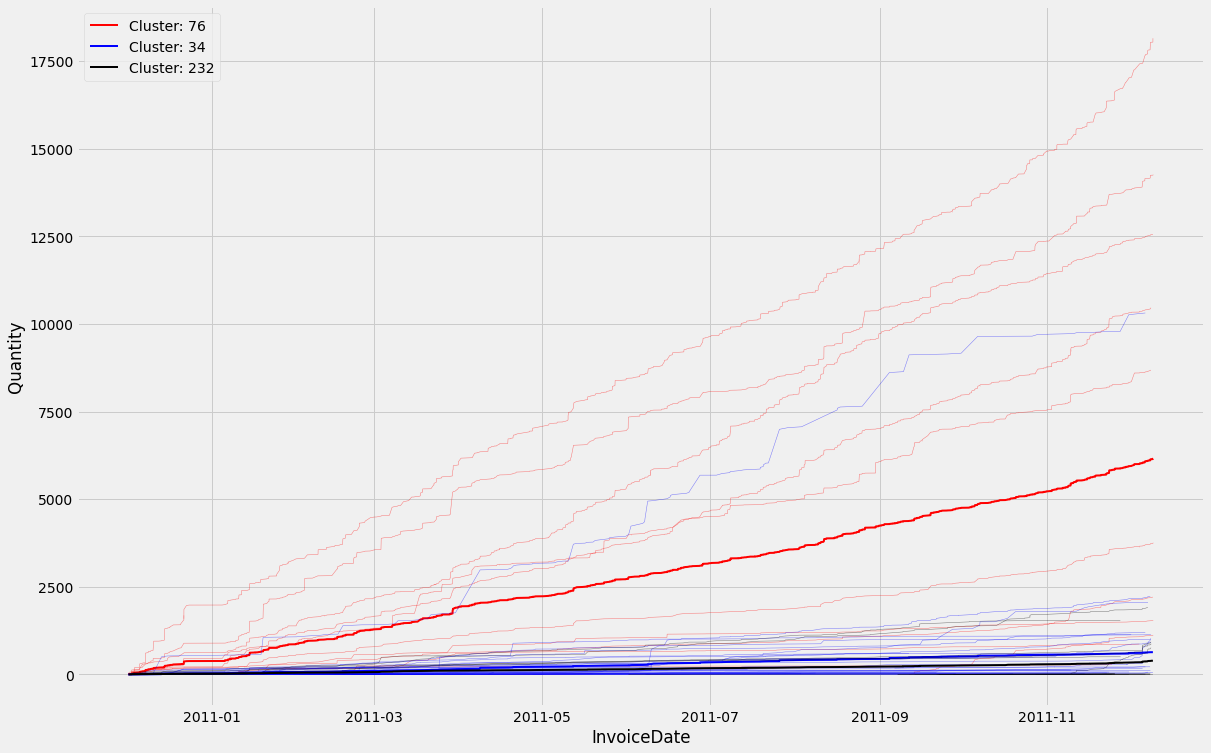

In [38]:
%%time
# @formatter:on

plt.figure(figsize = (18, 12))
unique_cluster_ids = df['ClusterId'].unique()
random_cluster_ids = np.random.choice(unique_cluster_ids.shape[0], 3, replace = False)
colors = ['red', 'blue', 'black']

# add max to product dfplot
for inx, c_id in enumerate(random_cluster_ids):

    cluster_df = df[df['ClusterId'] == unique_cluster_ids[c_id]]
    products = cluster_df['StockCodeNum'].unique().tolist()

    for pr in products:
        product_df = cluster_df[cluster_df['StockCodeNum'] == pr]
        ax1 = sns.lineplot(x = product_df['InvoiceDate'],
                           y = product_df['Quantity'].cumsum(),
                           linestyle = '-',
                           linewidth = 0.5,
                           color = colors[inx], alpha = 0.5)

    sns.lineplot(x = cluster_df['InvoiceDate'],
                 y = cluster_df['Quantity'].cumsum() / len(products),
                 label = f'Cluster: {int(unique_cluster_ids[c_id])}',
                 linestyle = '-',
                 linewidth = 2,
                 color = colors[inx])



Wall time: 42.8 s


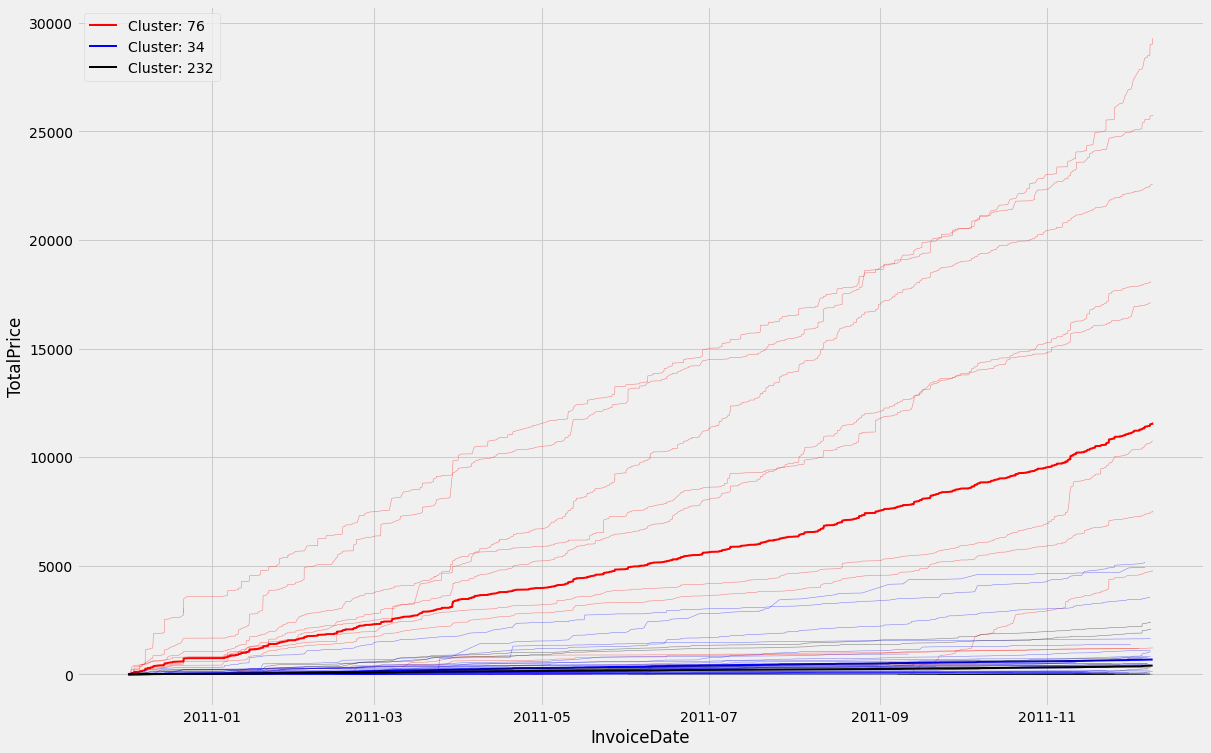

In [39]:
%%time
# @formatter:on

plt.figure(figsize = (18, 12))

for inx, c_id in enumerate(random_cluster_ids):

    cluster_df = df[df['ClusterId'] == unique_cluster_ids[c_id]]
    products = cluster_df['StockCodeNum'].unique().tolist()

    for pr in products:
        product_df = cluster_df[cluster_df['StockCodeNum'] == pr]
        ax1 = sns.lineplot(x = product_df['InvoiceDate'],
                           y = product_df['TotalPrice'].cumsum(),
                           linestyle = '-',
                           linewidth = 0.5,
                           color = colors[inx], alpha = 0.5)

    sns.lineplot(x = cluster_df['InvoiceDate'],
                 y = cluster_df['TotalPrice'].cumsum() / len(products),
                 label = f'Cluster: {int(unique_cluster_ids[c_id])}',
                 linestyle = '-',
                 linewidth = 2,
                 color = colors[inx])



Wall time: 2min 6s


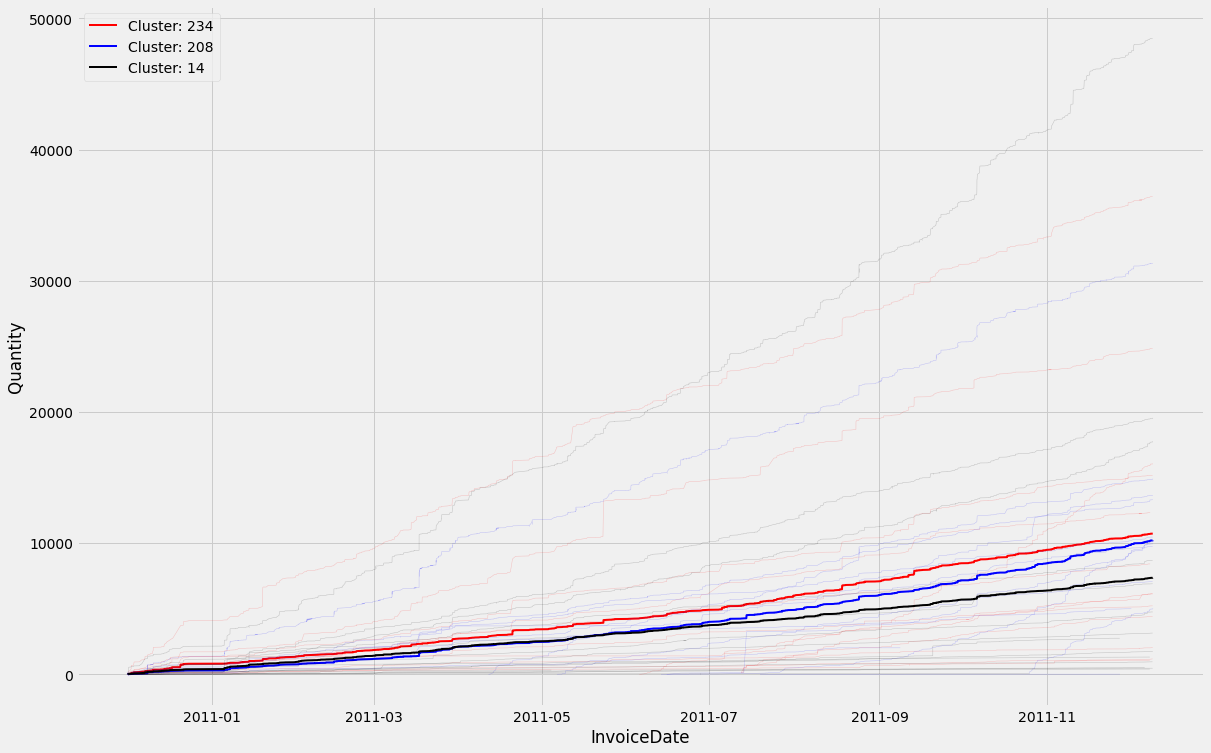

In [40]:
%%time
# @formatter:on

top_quantity_sum_cluster_ids = df.sort_values(by = ['ClusterIdQuantitySum'],
                                              ascending = False).drop_duplicates(subset = ['ClusterId']).head(3)['ClusterId'].tolist()
plt.figure(figsize = (18, 12))

for inx, cluster_id in enumerate(top_quantity_sum_cluster_ids):

    cluster_df = df[df['ClusterId'] == cluster_id]
    products = cluster_df['StockCodeNum'].unique().tolist()

    for pr in products:
        product_df = cluster_df[cluster_df['StockCodeNum'] == pr]
        ax1 = sns.lineplot(x = product_df['InvoiceDate'],
                           y = product_df['Quantity'].cumsum(),
                           linestyle = '-',
                           linewidth = 0.5,
                           color = colors[inx], alpha = 0.2)

    sns.lineplot(x = cluster_df['InvoiceDate'],
                 y = cluster_df['Quantity'].cumsum() / len(products),
                 label = f'Cluster: {int(cluster_id)}',
                 linestyle = '-',
                 linewidth = 2,
                 color = colors[inx])



Wall time: 3min 35s


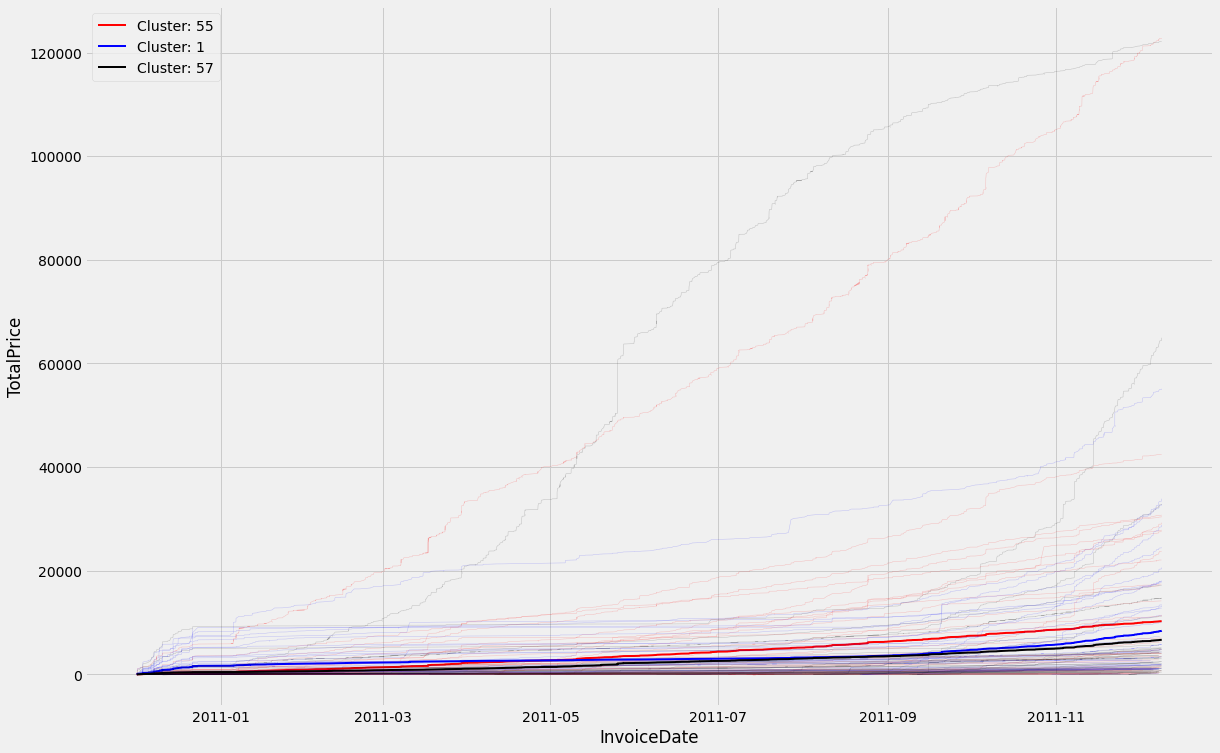

In [52]:
%%time
# @formatter:on

top_total_price_sum_cluster_ids = df.sort_values(by = ['ClusterIdTotalPriceSum'],
                                                 ascending = False).drop_duplicates(subset = ['ClusterId']).head(3)['ClusterId'].tolist()
plt.figure(figsize = (18, 12))

for inx, cluster_id in enumerate(top_total_price_sum_cluster_ids):

    cluster_df = df[df['ClusterId'] == cluster_id]
    products = cluster_df['StockCodeNum'].unique().tolist()

    for pr in products:
        product_df = cluster_df[cluster_df['StockCodeNum'] == pr]
        ax1 = sns.lineplot(x = product_df['InvoiceDate'],
                           y = product_df['TotalPrice'].cumsum(),
                           linestyle = '-',
                           linewidth = 0.5,
                           color = colors[inx], alpha = 0.2)

    sns.lineplot(x = cluster_df['InvoiceDate'],
                 y = cluster_df['TotalPrice'].cumsum() / len(products),
                 label = f'Cluster: {int(cluster_id)}',
                 linestyle = '-',
                 linewidth = 2,
                 color = colors[inx])

